# Context-based model: BioBert


For this type of models a context is needed in the training phase and inference phase. The **context** is a sequence of text from which the answer can be extracted, it was retrieved, as previously explained, from MedPub dataset using their API.

BioBERT is a biomedical language representation model designed for biomedical text mining tasks such as biomedical named entity recognition, relation extraction, question answering, etc.

The overall process of pre-training and fine-tuning BioBERT is ashown above.
* First, BioBERT is intialized with weights from BERT, which was pretrained on general domain corpora (English Wikipedia and BooksCorpus).
* Then, BioBERT is pre-trained on biomedical domain corpora (PubMed abstracts and PMC full-text articles).
* Finally, BioBERT is fine-tuned and evaluated on three popular biomedical text mining tasks (NER, RE and QA).

We use Biobert for our dataset, fine tuning it accoording to question-answering task

In [ ]:
TRAIN_MODEL = False
DOWNLOAD_DATASET = False    # Set to True if you want to download the huggingface dataset and re-split it (note that by doing it you will have a different split of the train-test)

## Configurations and imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os

path = 'Colab Notebooks/NLP_project'

os.chdir(f'/content/drive/MyDrive/{path}')
os.getcwd()

Mounted at /content/drive


'/content/drive/MyDrive/Colab Notebooks/NLP_project'

In [ ]:
!pip install datasets
!pip install -U sentence-transformers
!pip install datasets
!pip install transformers torch tensorflow pandas numpy
!pip3 install accelerate -U
!pip install bert-score


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 5.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64

In [ ]:
import pandas as pd
from datasets import load_dataset, Dataset
from datasets import load_from_disk
from bert_score import BERTScorer
from transformers import pipeline
from transformers import AutoTokenizer
from transformers import AutoModelForQuestionAnswering
import numpy as np
from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer
from transformers import DefaultDataCollator
from datasets import load_metric
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import pandas as pd
from datasets import Dataset
import matplotlib.pyplot as plt


## Dataset import

On this part the dataset is imported from the source, furthermore the context is extracted from .csv file. There is a small number of questions that doesn't have a context and they were discarded. At the end the join on the two tables is performed

In [ ]:
if DOWNLOAD_DATASET:
  raw_dataset =  load_dataset("medalpaca/medical_meadow_medical_flashcards", download_mode="force_redownload")

  #read the contextes from dataframe and join with answer-questions pairs
  df_context = pd.read_csv('questions_context_dataframe.csv')
  df_context.drop(df_context.columns[[1,2,3,4,5,6]], axis=1, inplace=True)
  raw_dataset_df = raw_dataset['train'].to_pandas()
  merged_df = pd.merge(raw_dataset_df, df_context, left_on='input',right_on='question', how='inner')
  merged_df.drop( merged_df.columns[[2,3]], axis=1, inplace=True)
  dataset = Dataset.from_pandas(merged_df)
  dataset = dataset.train_test_split(test_size=0.1)

  #dataset = dataset["train"].train_test_split(test_size=0.1)
  train_validation_split = dataset["train"].train_test_split(test_size=0.1)
  dataset["train"] = train_validation_split["train"]
  dataset["validation"] = train_validation_split["test"]
  dataset
else:
  dataset = load_from_disk("dataset_biobert")

In [ ]:
if DOWNLOAD_DATASET:
  #data are saved in order not to mix test and training
  dataset.save_to_disk("dataset_biobert")

Saving the dataset (0/1 shards):   0%|          | 0/27650 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3414 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3073 [00:00<?, ? examples/s]

In [ ]:
dataset = dataset.filter(lambda example: example["input"] != "")

Filter:   0%|          | 0/27650 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3414 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3073 [00:00<?, ? examples/s]

## Train the model

Here we train only Biobert and fine tune it on our dataset, however there is a data we don't have: starting_index: it specifies where the answer is located in the context, since we don't have this information we set it to 0 index, also the ending_index is set to 0

###BioBert

In [ ]:
if TRAIN_MODEL:
  tokenizer = AutoTokenizer.from_pretrained("biobert-base-cased-v1.2")
  output_dir = "2_biobert_qa_model"
  model = AutoModelForQuestionAnswering.from_pretrained("biobert-base-cased-v1.2")
  data_collator = DefaultDataCollator()

  ### TRAINING SET ###
  # Convert the dataset to a dictionary
  data_dict = dataset["train"].to_dict()
  # Create a DataFrame from the dictionary
  df = pd.DataFrame.from_dict(data_dict)

  questions = [q.strip() for q in df["input"]]
  context = [q.strip() for q in df["contexts"]]
  inputs = tokenizer(
          questions,
          context,
          max_length=512,
          truncation="only_second",
          return_offsets_mapping=True,
          padding="max_length",
      )

  offset_mapping = inputs.pop("offset_mapping")

  start_positions = []
  end_positions = []
  answers = df['output']
  for i, offset in enumerate(offset_mapping):
      answer = answers[i]
      start_char = 0
      end_char = 0 + len(answer)
      sequence_ids = inputs.sequence_ids(i)

      # Find the start and end of the context
      idx = 0
      while sequence_ids[idx] != 1:
          idx += 1
      context_start = idx
      while sequence_ids[idx] == 1:
          idx += 1
      context_end = idx - 1

      # If the answer is not fully inside the context, label it (0, 0)
      if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
          start_positions.append(0)
          end_positions.append(0)
      else:
          # Otherwise it's the start and end token positions
          idx = context_start
          while idx <= context_end and offset[idx][0] <= start_char:
              idx += 1
          start_positions.append(idx - 1)

          idx = context_end
          while idx >= context_start and offset[idx][1] >= end_char:
              idx -= 1
          end_positions.append(idx + 1)

  df["start_positions"] = start_positions
  df["end_positions"] = end_positions

  data = {'input_ids': inputs['input_ids'],
          'attention_mask': inputs['attention_mask'],
          'start_positions':start_positions,
          'end_positions': end_positions,
        }
  df = pd.DataFrame(data)
  train = Dataset.from_pandas(df)

  ### VALIDATION SET ###
  # Convert the dataset to a dictionary
  data_dict = dataset["validation"].to_dict()
  # Create a DataFrame from the dictionary
  df = pd.DataFrame.from_dict(data_dict)

  questions = [q.strip() for q in df["input"]]
  context = [q.strip() for q in df["contexts"]]
  inputs = tokenizer(
          questions,
          context,
          max_length=512,
          truncation="only_second",
          return_offsets_mapping=True,
          padding="max_length",
      )

  offset_mapping = inputs.pop("offset_mapping")

  start_positions = []
  end_positions = []
  answers = df['output']
  for i, offset in enumerate(offset_mapping):
      answer = answers[i]
      start_char = 0
      end_char = 0 + len(answer)
      sequence_ids = inputs.sequence_ids(i)

      # Find the start and end of the context
      idx = 0
      while sequence_ids[idx] != 1:
          idx += 1
      context_start = idx
      while sequence_ids[idx] == 1:
          idx += 1
      context_end = idx - 1

      # If the answer is not fully inside the context, label it (0, 0)
      if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
          start_positions.append(0)
          end_positions.append(0)
      else:
          # Otherwise it's the start and end token positions
          idx = context_start
          while idx <= context_end and offset[idx][0] <= start_char:
              idx += 1
          start_positions.append(idx - 1)

          idx = context_end
          while idx >= context_start and offset[idx][1] >= end_char:
              idx -= 1
          end_positions.append(idx + 1)

  df["start_positions"] = start_positions
  df["end_positions"] = end_positions

  data = {'input_ids': inputs['input_ids'],
          'attention_mask': inputs['attention_mask'],
          'start_positions':start_positions,
          'end_positions': end_positions,
        }
  df = pd.DataFrame(data)
  validation = Dataset.from_pandas(df)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/462 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:

training_args = TrainingArguments(
    output_dir=output_dir,
    eval_strategy="steps",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.01,
    report_to=[],
    logging_dir="./logs",
    load_best_model_at_end=True
)

def compute_metrics(p):
    predictions, labels = p.predictions, p.label_ids

    # Convert tuples to numpy arrays
    predictions = np.array(predictions)
    labels = np.array(labels)

    # Assuming your model outputs logits and you want to get predictions
    predictions = np.argmax(predictions, axis=2)
    labels = labels

    # Flatten the predictions and labels
    predictions = predictions.flatten()
    labels = labels.flatten()

    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='macro')
    recall = recall_score(labels, predictions, average='macro')
    f1 = f1_score(labels, predictions, average='macro')

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train,
    eval_dataset=validation,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

if TRAIN_MODEL:
  trainer.train()
  trainer.save_model()
  results = trainer.evaluate()
  results

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
500,2.862900,2.191670,0.544582,0.173579,0.142231,0.140013
1000,2.198700,2.129634,0.538562,0.195050,0.145707,0.145883
1500,2.149800,2.110300,0.534006,0.189480,0.143856,0.142969


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## model evaluation

###BioBert fine-tuning

Inference from the model is performed in batch, test set is splitted into n_splits parts, this is done in order to avoid overloading RAM resources.
And only a part of them is used to make inference

In [ ]:
output_dir = "2_biobert_qa_model"
model = AutoModelForQuestionAnswering.from_pretrained(output_dir)
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.2")

question_answerer = pipeline("question-answering", model=model , tokenizer=tokenizer)
scorer = BERTScorer(lang='en')

n_splits = 160
sections = np.linspace(0, len(dataset["test"]["input"]), n_splits+1)
n_sections = 4

P = np.array([])
R = np.array([])
F1 = np.array([])

for i in range(n_sections):
  print(i)
  first_index = int(sections[i])
  second_index= int(sections[i+1])
  results = question_answerer(question=dataset["test"]["input"][first_index : second_index], context=dataset["test"]["contexts"][first_index : second_index])
  results = pd.DataFrame(results)
  P_2, R_2, F1_2 = scorer.score(list(results["answer"]), dataset["test"]["output"][first_index : second_index])
  P = np.append(P, P_2)
  R = np.append(R, R_2)
  F1 = np.append(F1, F1_2)
  print(f"BERTScore Precision : {np.mean(P):.4f}, Recall: {np.mean(R):.4f}, F1: {np.mean(F1):.4f}  #samples: {int((len(dataset['test']['input'])/n_splits)*(i+1))}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


0
BERTScore Precision : 0.8289, Recall: 0.8007, F1: 0.8143  #samples: 21
1
BERTScore Precision : 0.8279, Recall: 0.8057, F1: 0.8163  #samples: 42
2
BERTScore Precision : 0.8301, Recall: 0.8033, F1: 0.8161  #samples: 64
3
BERTScore Precision : 0.8301, Recall: 0.8034, F1: 0.8162  #samples: 85


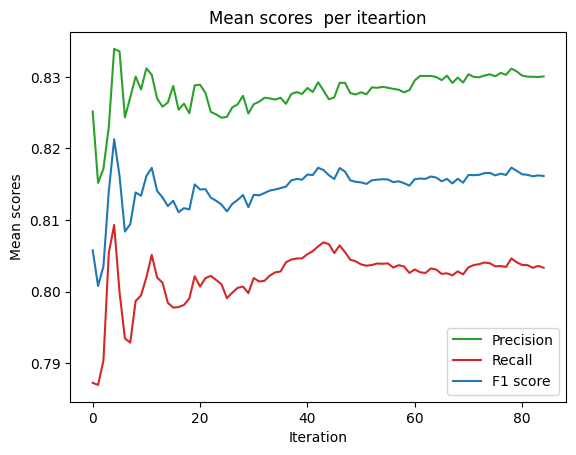

In [ ]:
def cum_mean(arr):
  cum_sum = np.cumsum(arr)
  return cum_sum/np.arange(1, len(arr) + 1)

plt.plot(cum_mean(P), color='#2ca02c',label='Precision')
plt.plot(cum_mean(R), color='#d62728',label='Recall')
plt.plot(cum_mean(F1),label='F1 score')

plt.ylabel('Mean scores')
plt.xlabel('Iteration')
plt.title("Mean scores  per iteartion")
plt.legend()
plt.show()

### raw model

Here BioBert and is avaluated on the data we have, the context retieved is used to make inference

In [ ]:
### BioBert ###

model_bio = "dmis-lab/biobert-base-cased-v1.2"
model = AutoModelForQuestionAnswering.from_pretrained(model_bio)
tokenizer = AutoTokenizer.from_pretrained(model_bio)

question_answerer = pipeline("question-answering", model=model , tokenizer=tokenizer)
scorer = BERTScorer(lang='en')

n_splits = 160
sections = np.linspace(0, len(dataset["test"]["input"]), n_splits+1)
n_sections = 4

P = np.array([])
R = np.array([])
F1 = np.array([])


for i in range(n_sections):
  print(i)
  first_index = int(sections[i])
  second_index= int(sections[i+1])
  results = question_answerer(question=dataset["test"]["input"][first_index : second_index], context=dataset["test"]["contexts"][first_index : second_index])
  results = pd.DataFrame(results)
  P_2, R_2, F1_2 = scorer.score(list(results["answer"]), dataset["test"]["output"][first_index : second_index])
  P = np.append(P, P_2)
  R = np.append(R, R_2)
  F1 = np.append(F1, F1_2)
  print(f"BERTScore Precision : {np.mean(P):.4f}, Recall: {np.mean(R):.4f}, F1: {np.mean(F1):.4f}  #samples: {int((len(dataset['test']['input'])/n_splits)*(i+1))}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.2 and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


0
BERTScore Precision : 0.8026, Recall: 0.7883, F1: 0.7950  #samples: 21
1
BERTScore Precision : 0.8072, Recall: 0.7954, F1: 0.8009  #samples: 42
2
BERTScore Precision : 0.8078, Recall: 0.7903, F1: 0.7985  #samples: 64
3
BERTScore Precision : 0.8084, Recall: 0.7921, F1: 0.7998  #samples: 85


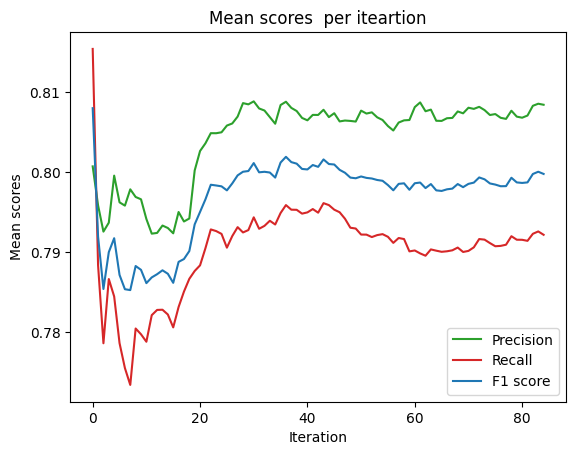

In [ ]:
def cum_mean(arr):
  cum_sum = np.cumsum(arr)
  return cum_sum/np.arange(1, len(arr) + 1)

plt.plot(cum_mean(P), color='#2ca02c',label='Precision')
plt.plot(cum_mean(R), color='#d62728',label='Recall')
plt.plot(cum_mean(F1),label='F1 score')

plt.ylabel('Mean scores')
plt.xlabel('Iteration')
plt.title("Mean scores  per iteartion")
plt.legend()
plt.show()

##conclusions

Comparing the two models performances have improved thanks to fine tuning however they are lower than other models, this is probably due to the missing starting index, ending index and the quality of the context retrieved.